In [1]:
import tensorflow as tf
import csv
import os
import pandas as pd
import numpy as np
import shutil
import PIL
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import piexif
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFile
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
labelsCsv = pd.read_csv("C:/Users/manta/Desktop/new.csv")

# When generating datasets from dataframe,using ImageDataGenerator, we noticed that train and valid sets
# had a class less than the test set. So comparing the labels we realised that one single tittle had the genre
# 'Game-Show' which we have to remove so each set has the same classes
labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Game-Show")]

nfiles = 0

# We remove exif metadata from pictures and resize them to max size of 128x128, while maintaining the aspect ratio
# of the original photo

#for filename in glob.iglob('C:/IMDB_dataset/*.jpg', recursive=True):
#    nfiles = nfiles + 1
#    print("About to process file %d, which is %s." % (nfiles,filename))
#    piexif.remove(filename)
size=(128, 128)
#for filename in glob.iglob('C:/IMDB_dataset/*.jpg', recursive=True):
    #im = Image.open(filename)
    #im.thumbnail(size, Image.ANTIALIAS)
    #x = filename.split("\\", 1)
    #im.save("C:/IMDB_resized/"+x[1], "JPEG")



In [3]:
all_genres = [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]
one_hot = MultiLabelBinarizer()
y_s =one_hot.fit_transform(np.array(all_genres))

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# creating and formating the dataset that we are going to use
d = {'filename' : [tconst + ".jpg" for tconst in labelsCsv.tconst],
    'labels' : [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]}

img_metadata_df = pd.DataFrame(d)

train, test = train_test_split(img_metadata_df, test_size=0.25, random_state=9, shuffle=True)
data_dir="C:/IMDB_resized/"
train_path = Path(data_dir, 'train.csv')
test_path = Path(data_dir, 'test.csv')
train.to_csv(train_path, sep=',', index=False)
test.to_csv(test_path, sep=',', index=False)

In [5]:
img_metadata_df

,filename,labels
0,tt0018295.jpg,"[Action, Drama, Short]"
1,tt0035423.jpg,"[Comedy, Fantasy, Romance]"
2,tt0068943.jpg,"[Documentary, Short]"
3,tt0088751.jpg,"[Comedy, Horror, Sci-Fi]"
4,tt0096056.jpg,[Drama]
...,...,...
51171,tt9907474.jpg,"[Drama, Short]"
51172,tt9907718.jpg,"[Drama, Short]"
51173,tt9909178.jpg,[Short]
51174,tt9909938.jpg,[Sci-Fi]


In [21]:
# defining the geerators that are going to pass batches of images during training
# rescaled and resized while performing a validation split in 0.2
img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

img_iter_train = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 9,
    directory="C:/IMDB_resized/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=50,
    subset='training'
) 

img_iter_val = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 9,
    directory="C:/IMDB_resized/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=200,
    subset='validation'
) 

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="C:/IMDB_resized/",
x_col='filename',
y_col='labels',
class_mode='categorical',
batch_size=1,
seed=9,
shuffle=False,
target_size=(128, 128)
)


Found 30706 validated image filenames belonging to 26 classes.
Found 7676 validated image filenames belonging to 26 classes.
Found 12794 validated image filenames belonging to 26 classes.


In [22]:
train.labels

26309              [Documentary, Short]
43197                     [Documentary]
47522                          [Comedy]
25036                           [Short]
43161                           [Short]
                      ...              
5014                    [Comedy, Short]
42747                           [Drama]
22584    [Adventure, Animation, Family]
501          [Action, Adventure, Drama]
20828                     [Documentary]
Name: labels, Length: 38382, dtype: object

In [42]:
# definging the model and compiling using Adam optimizer with a learning
# rate of 0.001 and metry validation accuracy
model = Sequential([
Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
    
Flatten(),
Dense(256, activation='relu'),
Dropout(0.5),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(26, activation='sigmoid')
])

model.compile(optimizer=Adam(lr = 0.0009), 
              loss='binary_crossentropy', 
              metrics=['accuracy','top_k_categorical_accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)       

In [44]:
es = EarlyStopping(monitor = 'val_top_k_categorical_accuracy',
                           mode = 'max',
                           verbose = 2,
                           patience = 6,
                           min_delta = 0.01,
                           restore_best_weights = True)

In [45]:
STEP_SIZE_TRAIN=img_iter_train.n//img_iter_train.batch_size
STEP_SIZE_VALID=img_iter_val.n//img_iter_val.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [46]:


history = model.fit_generator(
    generator = img_iter_train,
    validation_data = img_iter_val,
    epochs=100,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps= STEP_SIZE_VALID,
    callbacks= [es]
)

Epoch 1/100
614/614 [==============================] - 33s 54ms/step - loss: 0.2248 - accuracy: 0.9220 - top_k_categorical_accuracy: 0.6767 - val_loss: 0.1957 - val_accuracy: 0.9312 - val_top_k_categorical_accuracy: 0.7339
Epoch 2/100
614/614 [==============================] - 33s 53ms/step - loss: 0.1996 - accuracy: 0.9308 - top_k_categorical_accuracy: 0.7371 - val_loss: 0.1929 - val_accuracy: 0.9318 - val_top_k_categorical_accuracy: 0.7205
Epoch 3/100
614/614 [==============================] - 32s 52ms/step - loss: 0.1965 - accuracy: 0.9313 - top_k_categorical_accuracy: 0.7389 - val_loss: 0.1908 - val_accuracy: 0.9319 - val_top_k_categorical_accuracy: 0.7351
Epoch 4/100
614/614 [==============================] - 31s 51ms/step - loss: 0.1936 - accuracy: 0.9316 - top_k_categorical_accuracy: 0.7391 - val_loss: 0.1909 - val_accuracy: 0.9309 - val_top_k_categorical_accuracy: 0.7313
Epoch 5/100
614/614 [==============================] - 32s 52ms/step - loss: 0.1926 - accuracy: 0.9317 - top

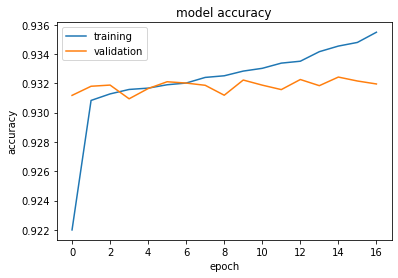

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

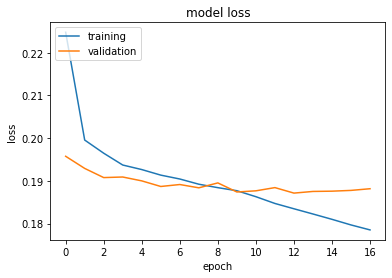

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [49]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

12794/12794 [==============================] - 77s 6ms/step


In [54]:
test_generator.reset()
model.evaluate_generator(generator = test_generator, 
                         steps=STEP_SIZE_TEST,
                         verbose=1)

12794/12794 [==============================] - 146s 11ms/step - loss: 0.1873 - accuracy: 0.9321 - top_k_categorical_accuracy: 0.7670


[0.18732895553857437, 0.9321393, 0.76700014]

In [55]:
model.save('C:/IMDB_resized/Model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:/IMDB_resized/Model/assets


In [32]:
#pred01 = pred
#pred01[pred01 >= 0.5] = 1
#pred01[pred01 < 0.5] = 0
np.savetxt("preds.csv", pred, delimiter=",")
#np.savetxt("preds01.csv", pred01, delimiter=",")

#print(pred)
#print(pred01)

In [50]:
predicted_class_indices=np.argmax(pred,axis=1)


In [51]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [52]:
labels

{0: 'Action',
 1: 'Adult',
 2: 'Adventure',
 3: 'Animation',
 4: 'Biography',
 5: 'Comedy',
 6: 'Crime',
 7: 'Documentary',
 8: 'Drama',
 9: 'Family',
 10: 'Fantasy',
 11: 'History',
 12: 'Horror',
 13: 'Music',
 14: 'Musical',
 15: 'Mystery',
 16: 'News',
 17: 'Reality-TV',
 18: 'Romance',
 19: 'Sci-Fi',
 20: 'Short',
 21: 'Sport',
 22: 'Talk-Show',
 23: 'Thriller',
 24: 'War',
 25: 'Western'}

In [53]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)